# Data Preparation

## Introduction
In this notebook we will preprocess the slides taken from the the [CAMELYON16](https://camelyon16.grand-challenge.org/Data/) dataset. The slides along with their respective tumor masks are available in this [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing), to allow easy access to these I have hosted the same data on [Google Cloud](https://storage.googleapis.com/dl-cancer-images).

We begin by installing [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency).

In [ ]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from tensorflow.python.keras.preprocessing import image as kp_image
import tensorflow as tf
import pandas as pd

In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

## Data Exploration

In [ ]:
# Download an example slide and tumor mask

slide_path = 'tumor_096.tif' # only this file is available
tumor_mask_path = 'tumor_096_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/dl-cancer-images/%s' % slide_path
mask_url = 'https://storage.googleapis.com/dl-cancer-images/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [ ]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels" % len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_096.tif with width: 131072, height: 71680
Read tumor mask from tumor_096_mask.tif
Slide includes 9 levels
Level 0, dimensions: (131072, 71680) downsample factor 1
Level 1, dimensions: (65536, 35840) downsample factor 2
Level 2, dimensions: (32768, 17920) downsample factor 4
Level 3, dimensions: (16384, 8960) downsample factor 8
Level 4, dimensions: (8192, 4480) downsample factor 16
Level 5, dimensions: (4096, 2240) downsample factor 32
Level 6, dimensions: (2048, 1120) downsample factor 64
Level 7, dimensions: (1024, 560) downsample factor 128
Level 8, dimensions: (512, 280) downsample factor 256


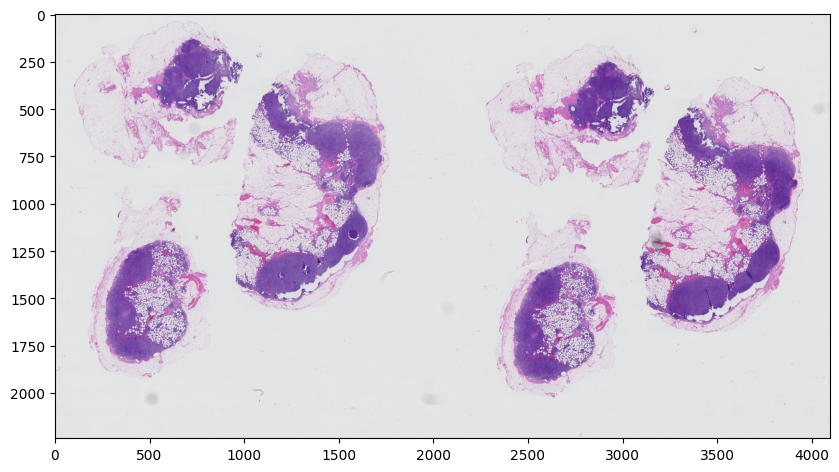

In [ ]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

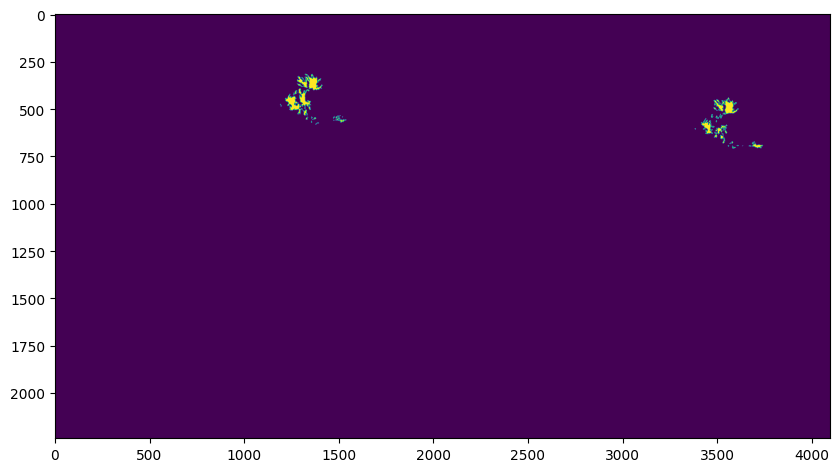

In [ ]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
mask_image = mask_image[:,:,0]
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

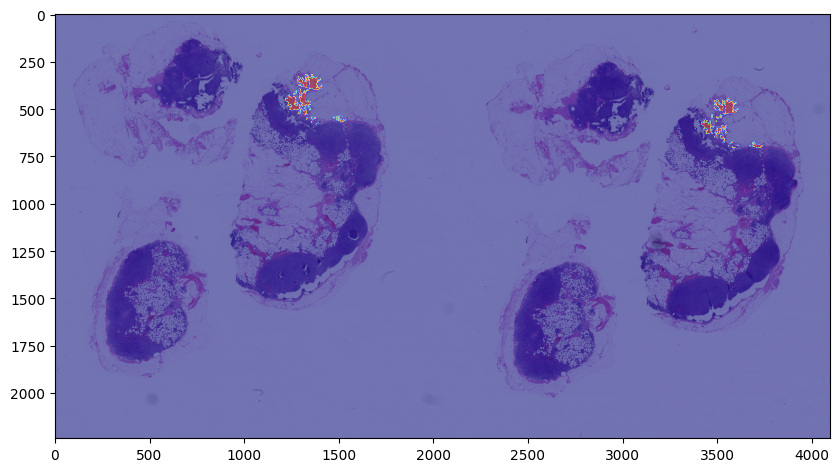

In [ ]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

## Data Preparation

- We use a sliding window approach to slide over the higher zoom levels and create labeled images of the slide segmentes, which we will later use for training and testing. 

- We have used the approach followed in the Paper, where we have a defined central window and we classify the image to contain tumor cells if the center contains atleast 1 pixel marked as a tumor. 

- The window size and center size has been chosen to be 80 and 50 respectively. This is because we are considering the images at a slightly lower zoom level as compared to the paper

- We have generated the data using a **multi-scale** approach and have used two diffenrent magnifications to prepare the dataset.

In [ ]:
# # We can improve efficiency by ignoring non-tissue areas 
# # of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(1,0,0)):
    masked = np.zeros_like(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [ ]:
def get_slide(slide_path):
  slide_url = f'https://storage.googleapis.com/dl-cancer-images/{slide_path}.tif'
  mask_url = f'https://storage.googleapis.com/dl-cancer-images/{slide_path}_mask.tif'

  # Download the whole slide image
  if not os.path.exists(f'{slide_path}.tif'):
    !curl -O $slide_url

  # Download the tumor mask
  if not os.path.exists(f'{slide_path}_mask.tif'):
    !curl -O $mask_url
def rm_slide(slide_path):
  slide_path = slide_path+'*'
  ! rm $slide_path

In [ ]:
# Download a list of available tumor slides
tumor_list_path = 'tumor.csv'
tumor_list_url = 'https://storage.googleapis.com/dl-cancer-images/%s' %tumor_list_path
if not os.path.exists(tumor_list_path):
  !curl -O $tumor_list_url
tumor_list = pd.read_csv(tumor_list_path)
np.random.shuffle(tumor_list.slides)

# Remove Slide for tumor_038 since it's corresponding mask was not available. 
tumor_list = tumor_list[tumor_list['slides'] != "tumor_038"].reindex()
tumor_list = tumor_list.slides.tolist()

In [ ]:
def check_centre(mask, centre):
    """
    Return true if the center has atleast one pixel marked as cancerous
    """
    diff = int((mask.shape[0]-centre)/2)

    return np.sum(mask[diff:diff+centre, diff:diff+centre]) > 0

In [ ]:
def generate_images(slide, slide_mask, level_1, level_2, window_size, center_size, stride):
  """
  The function generates training data at two different magifications.

  It first generates data using the 

  """

  tumor_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level_1, 
                         width=tumor.level_dimensions[level_1][0], 
                         height=tumor.level_dimensions[level_1][1])
  
  

  tumor_mask_image = read_slide(slide_mask, 
                         x=0, 
                         y=0, 
                         level=level_1, 
                         width=tumor.level_dimensions[level_1][0], 
                         height=tumor.level_dimensions[level_1][1])
  
  tumor_mask_image = tumor_mask_image[:,:,0]
  print("Loaded Level 1")
  patch_images = []
  patch_labels = []
  patch_center = []
  patch_coord  = []
  
  count = 0
  tumor_count = 0
  health_count = 1

  for i in range(window_size//2, slide.level_dimensions[level_1][1] - window_size - stride, stride):
    for j in range(window_size//2, slide.level_dimensions[level_1][0] - window_size - stride, stride):
      
      patch = tumor_image[i:i+window_size, j:j+window_size]
      tumor_mask_patch = tumor_mask_image[i:i+window_size, j:j+window_size]
      
      tissue_pixels = find_tissue_pixels(patch)
      tissue_pixels = list(tissue_pixels)
      percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[0]) * 100

      # If contains a tumor in the center
      if check_centre(tumor_mask_patch, center_size):
        patch_images.append(patch)
        patch_labels.append(1)
        patch_coord.append((j, i))
        patch_center.append((j+window_size//2, i+window_size//2))
        tumor_count += 1
        continue
        
      # If healthy keep only if the image patch contains more than 50% tissue
      # and sample to keep the memory size small

      if percent_tissue > 75:
        if (health_count < tumor_count) or (np.random.uniform() > (1 - tumor_count/(health_count+tumor_count))):
          patch_images.append(patch)
          patch_labels.append(0)
          patch_coord.append((j, i))
          patch_center.append((j+window_size//2, i+window_size//2))
          health_count += 1
        
      count += 1
      if count % 2000 == 0:
        print(count, tumor_count, health_count, end = " | ")

  del tumor_image
  del tumor_mask_image
  print("\n Deleted Level 1")

  tumor_ids = [id for id in range(len(patch_labels)) if int(patch_labels[id]) == 1]
  normal_ids = [id for id in range(len(patch_labels)) if int(patch_labels[id]) == 0]

  num_pos_imgs = len(tumor_ids)
  num_neg_imgs = len(normal_ids)
  print(num_pos_imgs, num_neg_imgs)

  num_imgs_min = min(num_pos_imgs, num_neg_imgs)

  # Randomly Shuffle the images
  np.random.shuffle(tumor_ids)
  np.random.shuffle(normal_ids)

  # Balance the dataset
  tumor_ids = tumor_ids[:num_imgs_min]
  normal_ids = normal_ids[:num_imgs_min]
  total_ids = tumor_ids + normal_ids
  np.random.shuffle(total_ids)

  patch_images = [patch_images[idx] for idx in total_ids]
  patch_labels = [patch_labels[idx] for idx in total_ids]
  patch_center = [patch_center[idx] for idx in total_ids]
  patch_coord = [patch_coord[idx] for idx in total_ids]
  tumor_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level_2, 
                         width=tumor.level_dimensions[level_2][0], 
                         height=tumor.level_dimensions[level_2][1])
  print("Loaded Level 2")
  patch_images_2 = []
  for center in patch_center:
      patch = tumor_image[center[1]//2-window_size//2:center[1]//2+window_size//2, center[0]//2-window_size//2:center[0]//2+window_size//2]
      assert patch.shape == (window_size, window_size, 3)
      patch_images_2.append(patch)
  del tumor_image
  print("\nDeleted Level 2")
  print("Done")      
  return patch_images, patch_images_2, patch_labels, patch_coord

In [ ]:
window_size=(80,80)
center_size=(50,50)
stride=50
level=3

In [ ]:
# 
train_list = ['tumor_110', 'tumor_031', 'tumor_035', 'tumor_019', 'tumor_057', 'tumor_096',  'tumor_005', 'tumor_081', 'tumor_012', 'tumor_023', 'tumor_094', 'tumor_016', 'tumor_084', 'tumor_001', 'tumor_059', 'tumor_101', 'tumor_078']
val_list = ['tumor_075', 'tumor_064']
test_list = ['tumor_091', 'tumor_002']
print(train_list)
print(test_list)
print(val_list)

['tumor_110', 'tumor_031', 'tumor_035', 'tumor_019', 'tumor_057', 'tumor_096', 'tumor_005', 'tumor_081', 'tumor_012', 'tumor_023', 'tumor_094', 'tumor_016', 'tumor_084', 'tumor_001', 'tumor_059', 'tumor_101', 'tumor_078']
['tumor_091', 'tumor_002']
['tumor_075', 'tumor_064']


In [ ]:
def save_data(patches, patches_2, labels, dir):
  
  if not os.path.exists(f"/gdrive/MyDrive/applied-slides/{dir}"):
    path = f"/gdrive/MyDrive/applied-slides/{dir}"
    !mkdir $path 
  Data_level_1 = np.asarray(patches)
  Data_level_2 = np.asarray(patches_2)
  Labels = np.asarray(labels)
  # print(Data_level_1.shape)
  np.save(f'/gdrive/MyDrive/applied-slides/{dir}/zoom_1',Data_level_1)
  np.save(f'/gdrive/MyDrive/applied-slides/{dir}/zoom_2',Data_level_2)
  np.save(f'/gdrive/MyDrive/applied-slides/{dir}/labels',Labels)

def cache_data(patches, patches_2, labels, tumor):

  Data_level_1 = np.asarray(patches)
  Data_level_2 = np.asarray(patches_2)
  Labels = np.asarray(labels)
  np.save(f'{tumor}_Data_level_1',Data_level_1)
  np.save(f'{tumor}_Data_level_2',Data_level_2)
  np.save(f'{tumor}_Labels',Labels)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
cd /content

/content


In [ ]:
for data_list, data_type in [(train_list, "train_80_fin_2"), (test_list, "test_80_fin_2"), (val_list, "val_80_fin_2")]:
  all_patches = []
  all_patches_2 = []
  all_labels = []
  for tumor_name in data_list:
    print(tumor_name, data_type)
    get_slide(tumor_name)
    tumor = open_slide(f'{tumor_name}.tif')
    tumor_mask = open_slide(f'{tumor_name}_mask.tif')
    patches, patches_2, labels, coord= generate_images(tumor, tumor_mask, level_1=3, level_2=4, 
                                    window_size=80, center_size=50, stride=50)
    
    cache_data(patches, patches_2, labels, tumor_name)
  for tumor_name in data_list:
    patches = np.load(f'{tumor_name}_Data_level_1.npy', allow_pickle=True)
    patches_2 = np.load(f'{tumor_name}_Data_level_2.npy', allow_pickle=True)
    labels = np.load(f'{tumor_name}_Labels.npy', allow_pickle=True)

    all_patches.extend(patches)
    all_patches_2.extend(patches_2)
    all_labels.extend(labels)
  save_data(all_patches, all_patches_2, all_labels, data_type)

tumor_110 train_80_fin_2
Loaded Level 1
2000 0 1 | 4000 0 1 | 6000 332 20 | 8000 1048 110 | 10000 2561 173 | 12000 3999 537 | 14000 4666 1167 | 16000 4861 2111 | 18000 5049 2966 | 20000 5324 3823 | 22000 5670 4516 | 24000 6232 4956 | 26000 6818 5139 | 28000 7226 5192 | 30000 7329 5195 | 32000 7329 5195 | 
 Deleted Level 1
7329 5194
Loaded Level 2

Deleted Level 2
Done
tumor_031 train_80_fin_2
Loaded Level 1
2000 0 1 | 4000 0 1 | 6000 0 1 | 8000 0 1 | 10000 0 1 | 12000 0 1 | 14000 0 1 | 16000 0 1 | 18000 0 1 | 20000 0 1 | 22000 0 1 | 24000 0 1 | 26000 0 1 | 28000 0 1 | 30000 0 1 | 32000 0 1 | 34000 0 1 | 36000 0 1 | 38000 0 1 | 40000 0 1 | 42000 0 1 | 44000 0 1 | 46000 0 1 | 48000 0 1 | 50000 0 1 | 52000 0 1 | 54000 0 1 | 56000 0 1 | 58000 0 1 | 60000 0 1 | 62000 0 1 | 64000 0 1 | 66000 0 1 | 68000 0 1 | 70000 0 1 | 72000 0 1 | 74000 0 1 | 76000 0 1 | 78000 0 1 | 80000 0 1 | 82000 0 1 | 84000 0 1 | 86000 71 61 | 88000 181 181 | 90000 276 309 | 92000 380 446 | 94000 528 561 | 96000 632 6